In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.dates as mdates

In [8]:
OFFSET = 570 #corresponds to minutes in day up to 9:30 am
custom_date_parser = lambda x: datetime.strptime(x, "%Y%m%d")

df = pd.read_csv("/Users/quinnhollister/Downloads/ibm_intraday_200306.txt", 
                 parse_dates=["DATE"], 
                 date_parser = custom_date_parser, delim_whitespace = True)

df["minsSinceOpen"] = (df["TIME"].str.split(':')).apply(lambda x: (int(x[0])*60 + int(x[1]) + int(x[2])*(1/60) - OFFSET))

In [11]:

print(len(df))
df = df[df['minsSinceOpen'] != 390.0]
print(len(df))


print(df.head())
#Now, I want to create 5-minute intervals throughout the trading day so i can run my
#analysis on trends. I'll copy this dataframe so that I don't lose any information, then
#I also want to erase the exact 4pm trades as they will contaminate the analysis.

163811
163796
        DATE     TIME  PRICE   SIZE  minsSinceOpen
0 2003-06-02  9:30:08   89.0  89800       0.133333
1 2003-06-02  9:30:09   89.0    200       0.150000
2 2003-06-02  9:30:09   89.0    100       0.150000
3 2003-06-02  9:30:09   89.0    300       0.150000
4 2003-06-02  9:30:09   89.0    200       0.150000


In [12]:
df["5minInt"] = pd.cut(df["minsSinceOpen"], np.arange(-0.000000000001, 395, 5), include_lowest=True, labels=False)
df["DAY"] = df["DATE"].dt.day
df.loc[:, 'tidx'] = pd.to_datetime(df['DATE'].astype(str) + ' ' + df['TIME'].astype(str))
print(df.head(10000))

            DATE     TIME  PRICE   SIZE  minsSinceOpen  5minInt  DAY  \
0     2003-06-02  9:30:08  89.00  89800       0.133333        0    2   
1     2003-06-02  9:30:09  89.00    200       0.150000        0    2   
2     2003-06-02  9:30:09  89.00    100       0.150000        0    2   
3     2003-06-02  9:30:09  89.00    300       0.150000        0    2   
4     2003-06-02  9:30:09  89.00    200       0.150000        0    2   
...          ...      ...    ...    ...            ...      ...  ...   
9996  2003-06-03  9:44:25  83.80  11500      14.416667        2    3   
9997  2003-06-03  9:44:26  83.75   6000      14.433333        2    3   
9998  2003-06-03  9:44:27  83.80    100      14.450000        2    3   
9999  2003-06-03  9:44:27  83.81    500      14.450000        2    3   
10000 2003-06-03  9:44:27  83.79    100      14.450000        2    3   

                     tidx  
0     2003-06-02 09:30:08  
1     2003-06-02 09:30:09  
2     2003-06-02 09:30:09  
3     2003-06-02 09:30:

In [13]:
#Now that we have these 5 minute ticks associated with each observation, we'll need to group_by the 5minInt
#and the date, and each new grouped observations needs to sum over the transaction volume, and the last
#stock price in that interval

def intervalVals(group):
    SIZE = np.sum(group["SIZE"])
    TRADES = group["SIZE"].count()
    idx = group["minsSinceOpen"].idxmax()
    startidx = group["minsSinceOpen"].idxmin()
    PRICE = group.loc[idx, ["PRICE"]].item()
    RET = np.log(group.loc[idx, ["PRICE"]].item()) - np.log(group.loc[startidx, ["PRICE"]].item())
    TIME = group.loc[idx, ["DATE"]].item() 
    PRICE_CHANGE = group.loc[idx, ["PRICE"]].item() - group.loc[startidx, ["PRICE"]].item()
    return [SIZE,PRICE,TIME,TRADES, RET, PRICE_CHANGE]

In [14]:
processed_df = df.groupby(["DAY", "5minInt"]).apply(intervalVals)


In [15]:
#lets print out this SIZE series, and realizing we have a multi-index need to convert back to timeseries
processed_df.head()
reset_df = processed_df.reset_index()
reset_df.rename(columns = {'DAY': 'DAY', '5minInt': '5minInt', 0: "VALS"}, inplace=True)


reset_df[["SIZE","PRICE","TIME","TRADES", "RET", "PRICE_CHANGE"]] = pd.DataFrame(reset_df["VALS"].tolist(), index = reset_df.index)
reset_df.drop(columns = ["VALS"], inplace=True)

pd.set_option("display.max_rows", None, "display.max_columns", None)
print(reset_df)

      DAY  5minInt     SIZE    PRICE       TIME  TRADES       RET  \
0       2        0   271500  88.8300 2003-06-02     265 -0.001912   
1       2        1   124500  88.5600 2003-06-02     102 -0.003157   
2       2        2    96300  88.4200 2003-06-02     108 -0.001582   
3       2        3   106200  88.4000 2003-06-02     123 -0.000113   
4       2        4   105600  88.5300 2003-06-02     127  0.001470   
5       2        5    98200  88.6900 2003-06-02      99  0.001693   
6       2        6   171100  88.5000 2003-06-02     146 -0.002032   
7       2        7   136400  88.6000 2003-06-02     137  0.001355   
8       2        8   152100  88.7400 2003-06-02     148  0.001579   
9       2        9    70000  88.5770 2003-06-02     109 -0.001839   
10      2       10    59500  88.3600 2003-06-02     118 -0.002261   
11      2       11    66600  88.6000 2003-06-02     119  0.002712   
12      2       12    86400  88.3700 2003-06-02     118 -0.001244   
13      2       13    69100  88.48

In [16]:
print(len(reset_df))
print(len(reset_df.dropna()))

1638
1638


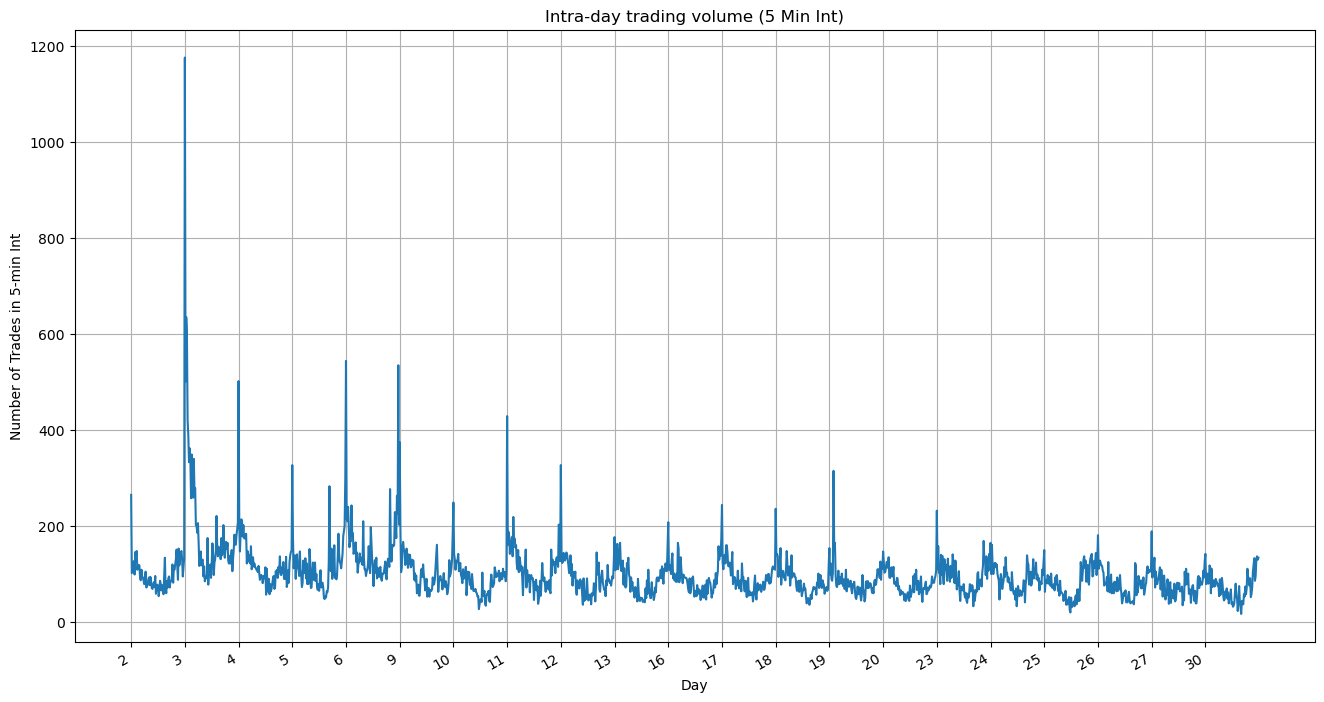

In [83]:
#Lets plot the time series and its ACF plot for the Volume of transactions in the 5 minute Intervals
plotting_df = reset_df.set_index(reset_df["DAY"])
rangeVal = len(plotting_df["SIZE"])
x = np.arange(rangeVal)

TIME_INTS_PER_DAY = 78
DAYS = len(reset_df) / TIME_INTS_PER_DAY
LAST_INDEX = len(reset_df)-1

fig, axes = plt.subplots(1, 1, figsize=(16, 9), dpi=100)


plt.xticks(np.arange(0, TIME_INTS_PER_DAY*DAYS, TIME_INTS_PER_DAY))
plt.grid()


labels = reset_df["DAY"].loc[0: TIME_INTS_PER_DAY*DAYS + TIME_INTS_PER_DAY: TIME_INTS_PER_DAY]

axes.plot(x, plotting_df["TRADES"])
axes.set_xticklabels(labels)
plt.ylabel("Number of Trades in 5-min Int")
plt.xlabel("Day")
plt.title("Intra-day trading volume (5 Min Int)")



fig.autofmt_xdate()
plt.show()

There's very clearly volatility clustering of the 5 minute volume time series chart. Also illustrates the U-shaped behaviour of trading, i.e. the most transactions seem to take place at the beginning and end of trading hours, whereas during the middle of the day, trading seems to be less frequent.  

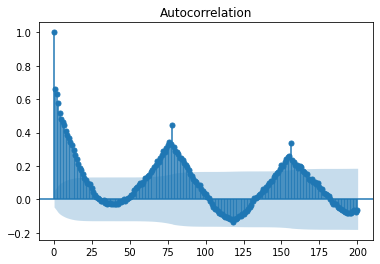

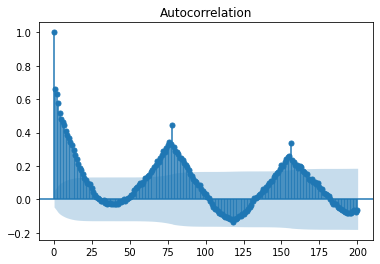

In [84]:
sm.graphics.tsa.plot_acf(reset_df["TRADES"], lags=200)

We expect this kind of behaviour in the ACF that there should be significant autocorrelation at lags of around multiples of 78 since we expect this U-shaped behaviour in the trading volume at the beginning and end of the day.

[Text(0.0, 0, '2'),
 Text(78.0, 0, '3'),
 Text(156.0, 0, '4'),
 Text(234.0, 0, '5'),
 Text(312.0, 0, '6'),
 Text(390.0, 0, '9'),
 Text(468.0, 0, '10'),
 Text(546.0, 0, '11'),
 Text(624.0, 0, '12'),
 Text(702.0, 0, '13'),
 Text(780.0, 0, '16'),
 Text(858.0, 0, '17'),
 Text(936.0, 0, '18'),
 Text(1014.0, 0, '19'),
 Text(1092.0, 0, '20'),
 Text(1170.0, 0, '23'),
 Text(1248.0, 0, '24'),
 Text(1326.0, 0, '25'),
 Text(1404.0, 0, '26'),
 Text(1482.0, 0, '27'),
 Text(1560.0, 0, '30')]

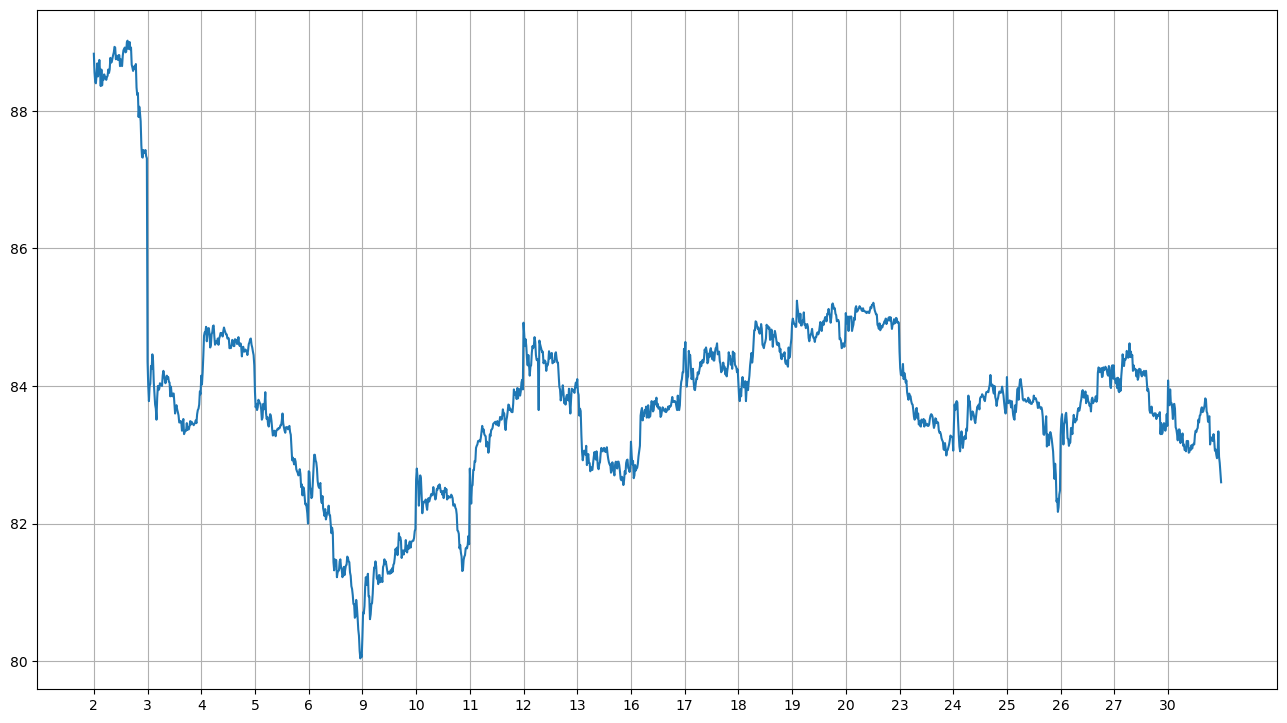

In [86]:
fig2, axes2 = plt.subplots(1, 1, figsize=(16, 9), dpi=100)


axes2.plot(reset_df["PRICE"])

plt.xticks(np.arange(0, TIME_INTS_PER_DAY*DAYS, TIME_INTS_PER_DAY))
plt.grid()
axes2.set_xticklabels(labels)

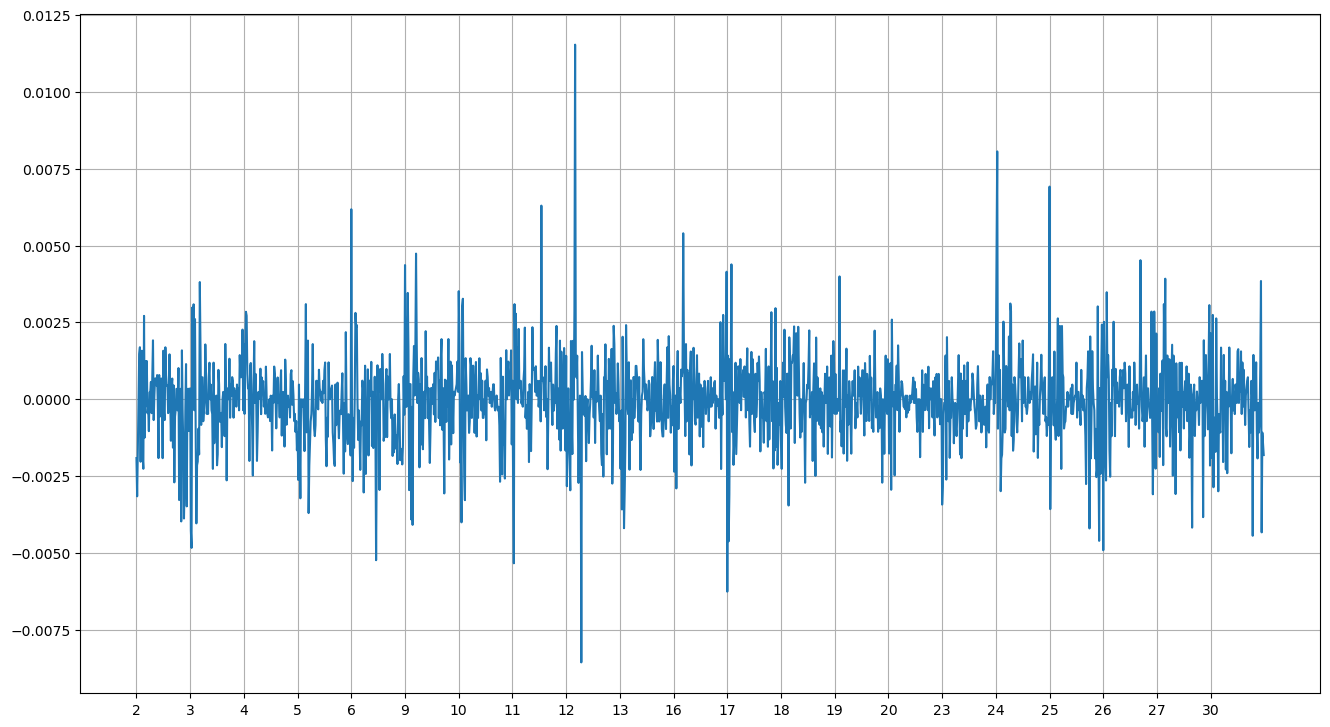

In [87]:
#but in order to get returns, we need to difference the data
fig3, axes3 = plt.subplots(1, 1, figsize=(16, 9), dpi=100)


plt.xticks(np.arange(0, TIME_INTS_PER_DAY*DAYS, TIME_INTS_PER_DAY))
plt.grid()
axes3.set_xticklabels(labels)

returns = reset_df["RET"]
axes3.plot(returns)

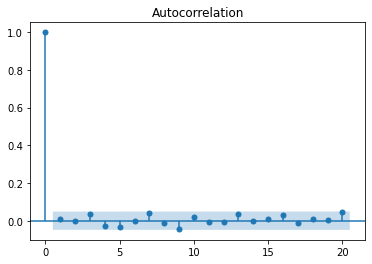

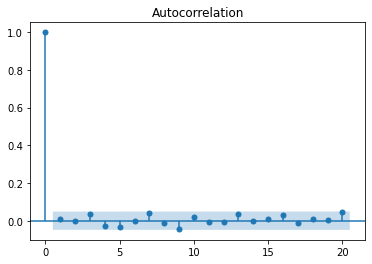

In [88]:
sm.graphics.tsa.plot_acf(returns.dropna(), lags=20)

No significant auto-correlations present for the return series. 

-0.013460930504661728


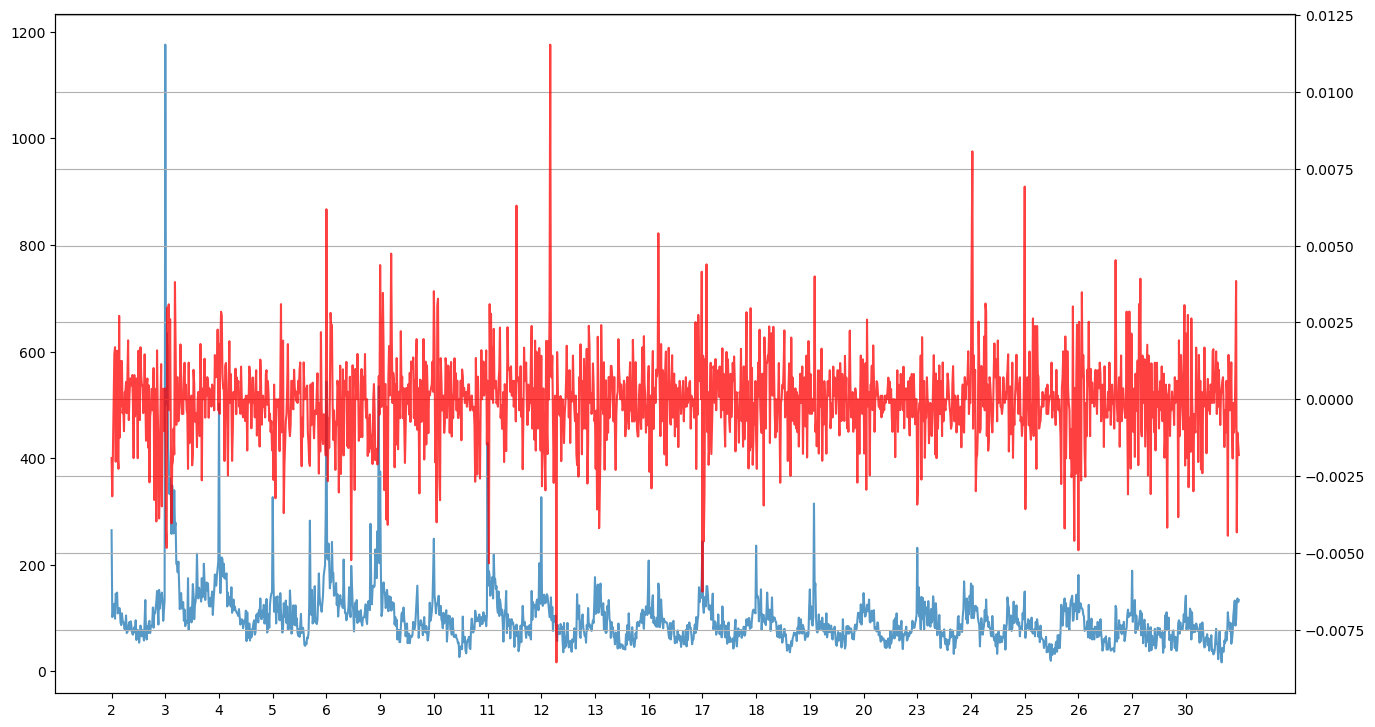

In [89]:
#Now lets plot the series (volume, returns)
fig4, axes4 = plt.subplots(1, 1, figsize=(16, 9), dpi=100)

axes4_right = axes4.twinx()

axes4.plot(reset_df["TRADES"], alpha = 0.75)
axes4_right.plot(returns, alpha = 0.75, color = "red")

plt.xticks(np.arange(0, TIME_INTS_PER_DAY*DAYS, TIME_INTS_PER_DAY))
plt.grid()
axes4.set_xticklabels(labels)


print(reset_df["TRADES"].corr(returns))

0.21272639072996638


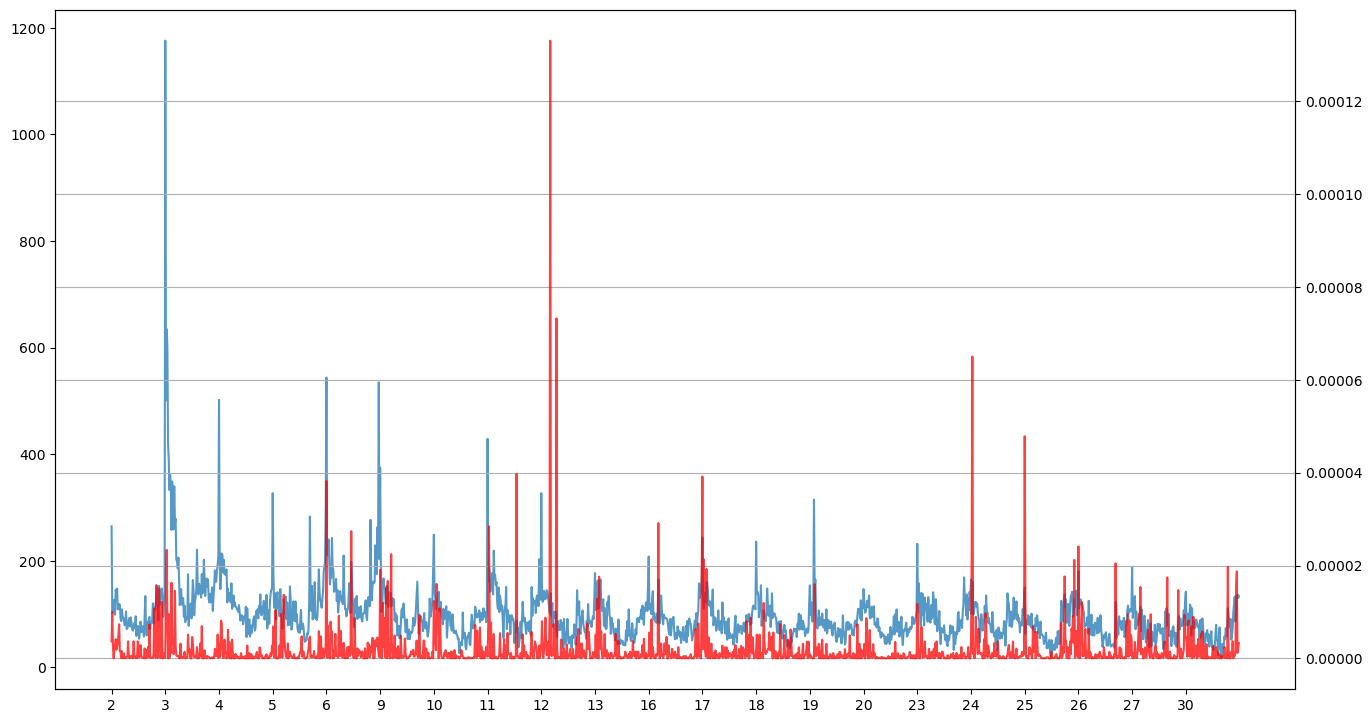

In [92]:
# Now, lets try to find a transformation g(y) s.t. we get some significant correlation between xt and yt.
returns_sq = returns**(2)


fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9), dpi=100)

axes5_right = axes5.twinx()

axes5.plot(reset_df["TRADES"], alpha = 0.75)
axes5_right.plot(returns_sq, alpha = 0.75, color = "red")


plt.xticks(np.arange(0, TIME_INTS_PER_DAY*DAYS, TIME_INTS_PER_DAY))
plt.grid()
axes5.set_xticklabels(labels)

print(reset_df["TRADES"].corr(returns_sq))

We expect there to be some correlation between the squared magnitude of the returns for an interval and the trading volume associated with that interval, since larger moves are likely to coincide with more trading behaviour. As we can see, when $g(y) = y^{2}$, $\rho^{2} = 0.2127 $

In [36]:
#Now lets tabulate the relative frequencies of price changes in multiples of tick size $0.0625
#We'll proceed by using the returns datframe, and changing it into a categorical variable.
TICKSIZE = 0.0625
priceChange = reset_df["PRICE_CHANGE"]
tabMin = int( abs( min(priceChange) / TICKSIZE) ) + 1
tabMax = int( abs( max(priceChange) / TICKSIZE) ) + 1
tabRange = np.arange(-1*tabMin*TICKSIZE, tabMax*TICKSIZE + TICKSIZE, TICKSIZE)
tabulate = pd.cut(priceChange, tabRange, include_lowest=False)


relFreq = tabulate.groupby(tabulate).count()
relFreq = np.divide(relFreq, relFreq.sum())
print(relFreq)

12
16
PRICE_CHANGE
(-0.75, -0.688]      0.000611
(-0.688, -0.625]     0.000000
(-0.625, -0.562]     0.000000
(-0.562, -0.5]       0.000611
(-0.5, -0.438]       0.000611
(-0.438, -0.375]     0.003053
(-0.375, -0.312]     0.007937
(-0.312, -0.25]      0.012210
(-0.25, -0.188]      0.029915
(-0.188, -0.125]     0.064713
(-0.125, -0.0625]    0.113553
(-0.0625, 0.0]       0.292430
(0.0, 0.0625]        0.261294
(0.0625, 0.125]      0.124542
(0.125, 0.188]       0.047619
(0.188, 0.25]        0.025031
(0.25, 0.312]        0.006105
(0.312, 0.375]       0.004274
(0.375, 0.438]       0.001832
(0.438, 0.5]         0.000611
(0.5, 0.562]         0.001221
(0.562, 0.625]       0.000611
(0.625, 0.688]       0.000611
(0.688, 0.75]        0.000000
(0.75, 0.812]        0.000000
(0.812, 0.875]       0.000000
(0.875, 0.938]       0.000000
(0.938, 1.0]         0.000611
Name: PRICE_CHANGE, dtype: float64


As we can see, the majority (about half) of the 5-min interval price changes occur in the band (-0.0625, 0.0625) as we would expect. Only a small portion of these intervals contain large price changes.